<a href="https://colab.research.google.com/github/somaharshithareddy/Projectss/blob/main/Phising%20Email%20Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [ ]:
try:
    df = pd.read_csv("/content/Phising.csv", encoding="utf-8")
except UnicodeDecodeError:
    try:
        df = pd.read_csv("/content/Phising.csv", encoding="ISO-8859-1")
    except UnicodeDecodeError:
        df = pd.read_csv("/content/Phising.csv", encoding="Windows-1252")

In [ ]:
print(df.head())

   Label                                         Email_Text
0      1  Congratulations! You've won a $1000 Walmart gi...
1      1  Urgent: Your bank account has been compromised...
2      1  Click this link to verify your account and avo...
3      1  Your account has been locked. Please verify yo...
4      1  Claim your free iPhone now! Click here to get ...


In [ ]:
print(df.isna().sum())

Label         0
Email_Text    0
dtype: int64


In [ ]:
texts = df["Email_Text"].tolist()
labels = df["Label"].tolist()

In [ ]:
model_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt")
labels = torch.tensor(labels)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)
model.train()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [ ]:
losses = []

for epoch in range(10):
    optimizer.zero_grad()
    outputs = model(**inputs, labels=labels)
    loss = outputs.loss
    loss.backward()
    optimizer.step()
    losses.append(loss.item())
    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")

Epoch 1, Loss: 0.6918780207633972
Epoch 2, Loss: 0.656348705291748
Epoch 3, Loss: 0.5731068253517151
Epoch 4, Loss: 0.4505968689918518
Epoch 5, Loss: 0.3492942154407501
Epoch 6, Loss: 0.2918590307235718
Epoch 7, Loss: 0.20063945651054382
Epoch 8, Loss: 0.14430038630962372
Epoch 9, Loss: 0.09947121888399124
Epoch 10, Loss: 0.06943187117576599


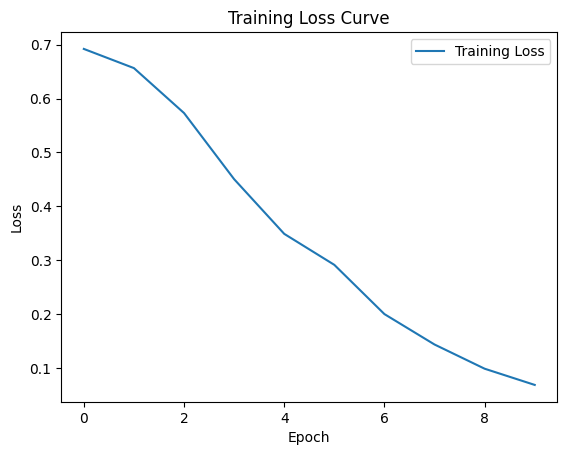

In [ ]:
plt.plot(losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.show()

In [ ]:
def detect_phishing(email_text):
    model.eval()
    inputs = tokenizer(email_text, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_label = torch.argmax(logits, dim=1).item()
    return predicted_label

In [ ]:
import numpy as np
model.eval()
predictions = []
with torch.no_grad():
    for text in texts:
        pred = detect_phishing(text)
        predictions.append(pred)


In [ ]:
labels = np.array(labels, dtype=np.int64)
predictions = np.array(predictions, dtype=np.int64)
accuracy = accuracy_score(labels, predictions)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

Model Accuracy: 100.00%


In [ ]:

test_emails = [
    "You have won a free iPhone! Click here to claim your prize.",
    "Your recent transaction was successful. Thank you for shopping with us.",
    "Your account has been locked. Please verify your identity to unlock it.",
]

for email in test_emails:
    result = detect_phishing(email)
    print(f"Email: {email}\nClassification: {result}\n")

Email: You have won a free iPhone! Click here to claim your prize.
Classification: 1

Email: Your recent transaction was successful. Thank you for shopping with us.
Classification: 0

Email: Your account has been locked. Please verify your identity to unlock it.
Classification: 1

